# Estimate latent time by using scVelo

## This is in Python

In [1]:
import psutil
psutil.virtual_memory()

svmem(total=202482765824, available=178047971328, percent=12.1, used=19302825984, free=155388940288, active=8238301184, inactive=17332441088, buffers=6430720, cached=27784568832, shared=4362858496, slab=4845969408)

In [2]:
#import scrublet as scr
import scipy.io
import os
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.colors import ListedColormap
import seaborn as sb
from gprofiler import GProfiler
from scipy import sparse
import scvelo as scv
scv.logging.print_version()

from rpy2.robjects.packages import importr
seuratLib = importr('Seurat')

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

import h5py
import anndata
from anndata import read_h5ad
import warnings
warnings.filterwarnings('ignore')

import utilities as ut
import inspect

%matplotlib inline

Running scvelo 0.1.25 (python 3.7.3) on 2020-05-19 00:57.


In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(15,15) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.9 numpy==1.17.3 scipy==1.3.2 pandas==0.25.0 scikit-learn==0.22 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [4]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

In [5]:
%%R

library(RColorBrewer)
library(ggplot2)
library(plyr)
library(Seurat)
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /fast/home/c/chsu/anaconda3/envs/cbpsc/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.utf-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.utf-8        LC_COLLATE=en_US.utf-8    
 [5] LC_MONETARY=en_US.utf-8    LC_MESSAGES=en_US.utf-8   
 [7] LC_PAPER=en_US.utf-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.utf-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] plyr_1.8.4         ggplot2_3.2.1      RColorBrewer_1.1-2 Seurat_3.0.2      

loaded via a namespace (and not attached):
 [1] httr_1.4.1          tidyr_1.0.0         viridisLite_0.3.0  
 [4] jsonlite_1.6        splines_3.6.1       lsei_1.2-0         
 [7] R.utils_2.9.1       g

## 1. Load data

In [7]:
%%R -o spliced -o unspliced -o meta -o var -o pca_int -o umap_int

load('./supp_data/Ground_Tissue_Atlas_scVelo_input.RData')

In [8]:
spliced = sparse.csr_matrix(spliced, dtype=np.float32)
unspliced = sparse.csr_matrix(unspliced, dtype=np.float32)
seu = anndata.AnnData(X=spliced.T, obs=meta, var=var, layers={'spliced':spliced.T, 'unspliced':unspliced.T}, obsm={'X_pca':pca_int,'X_umap':umap_int})
seu.var.rename(columns={0:'gene_id'}, inplace=True)
seu.var.set_index('gene_id', inplace=True)
seu.shape

(23687, 17513)

## 2. Run scVelo with dynamical mode

In [9]:
scv.utils.show_proportions(seu)
scv.pp.moments(seu, n_pcs=50, n_neighbors=100)
scv.tl.recover_dynamics(seu)
scv.tl.velocity(seu, mode='dynamical')
scv.tl.velocity_graph(seu)

Abundance of ['spliced', 'unspliced']: [0.87 0.13]
computing neighbors
    finished (0:00:24) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:35) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
recovering dynamics
    finished (12:40:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:10:13) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:27:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## 3. RNA velocity

computing velocity embedding
    finished (0:00:09) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


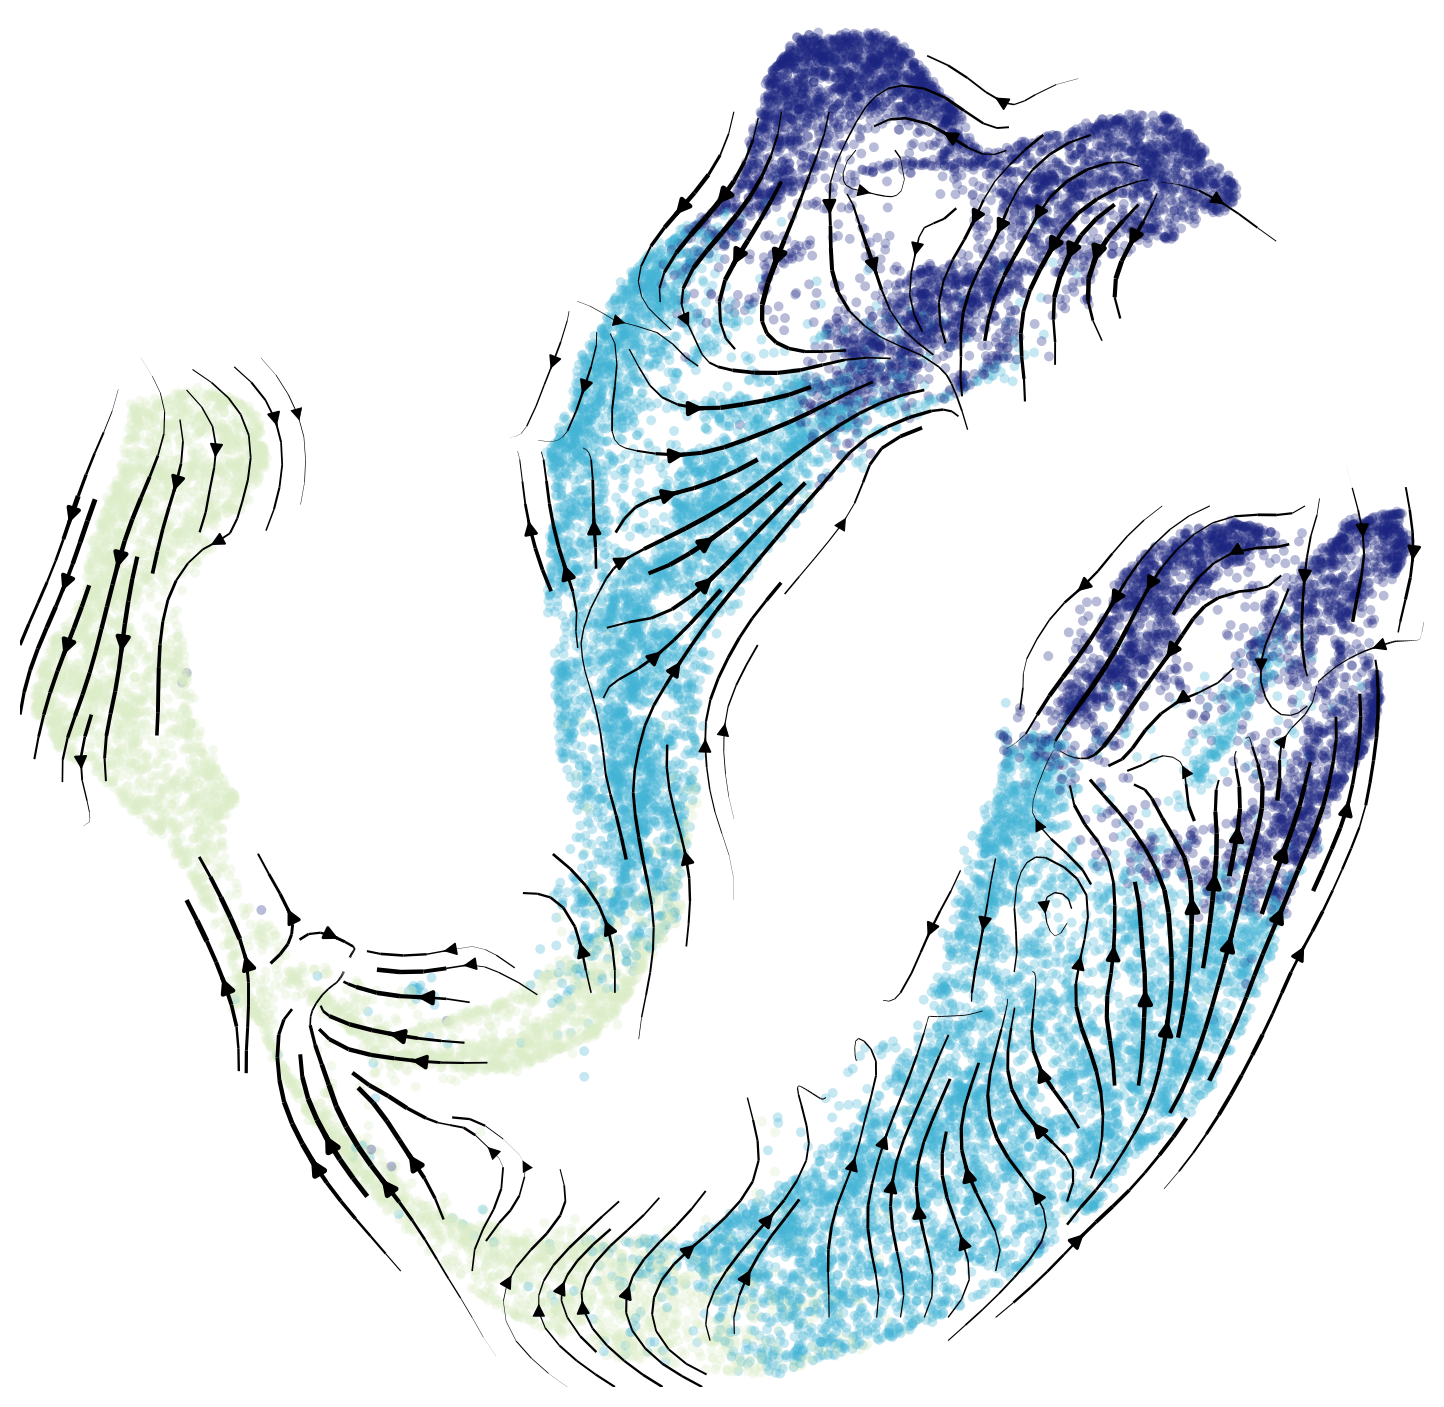

In [10]:
seu.uns['time.anno_colors'] = np.array(["#DCEDC8", "#42B3D5", "#1A237E"], dtype=object)
scv.pl.velocity_embedding_stream(seu, basis='umap', color=['time.anno'], size=50, alpha=0.3, legend_loc='none', figsize=(9,9), title="")

## 4. Latent time estimation

computing terminal states
    identified 1 region of root cells and 2 regions of end points 
    finished (0:00:07) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time
    finished (0:02:53) --> added 
    'latent_time', shared time (adata.obs)


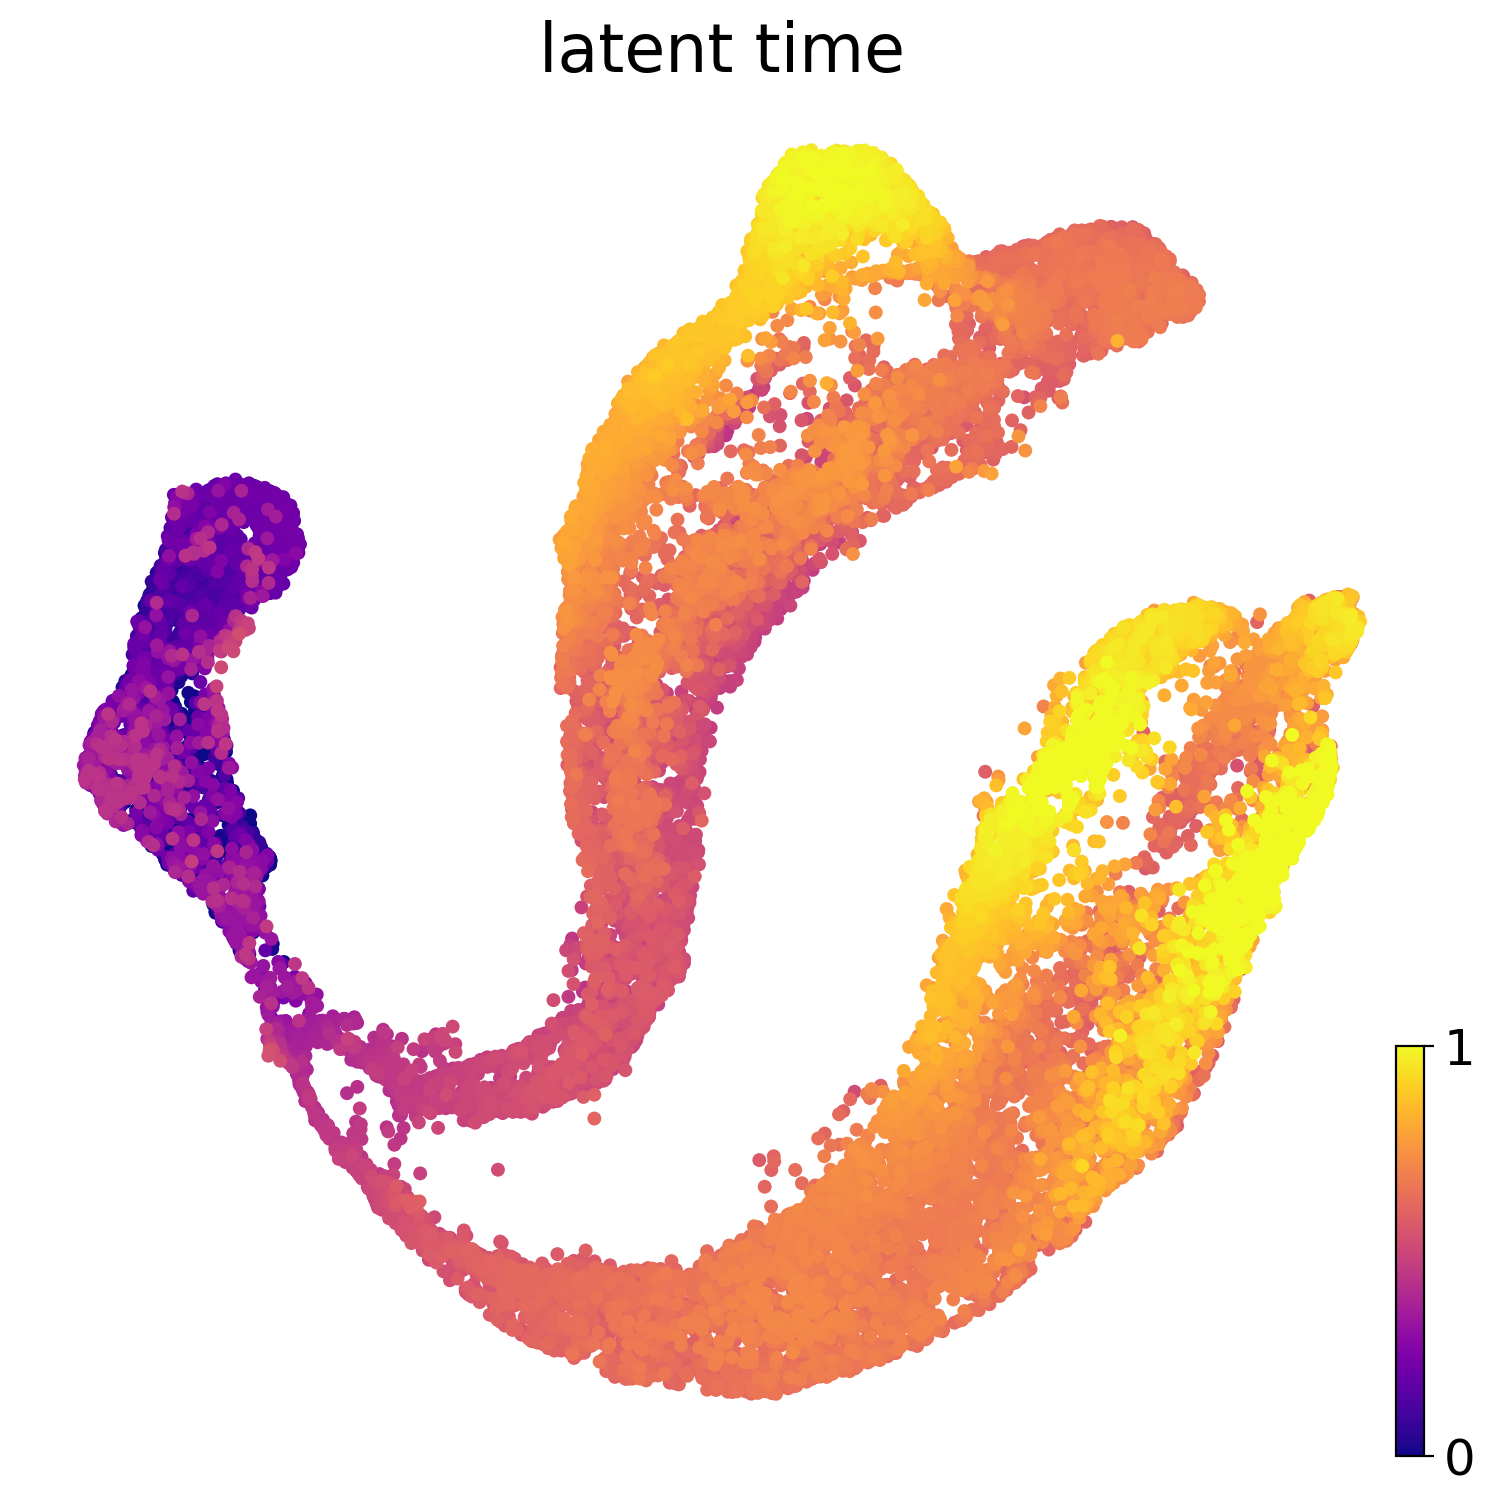

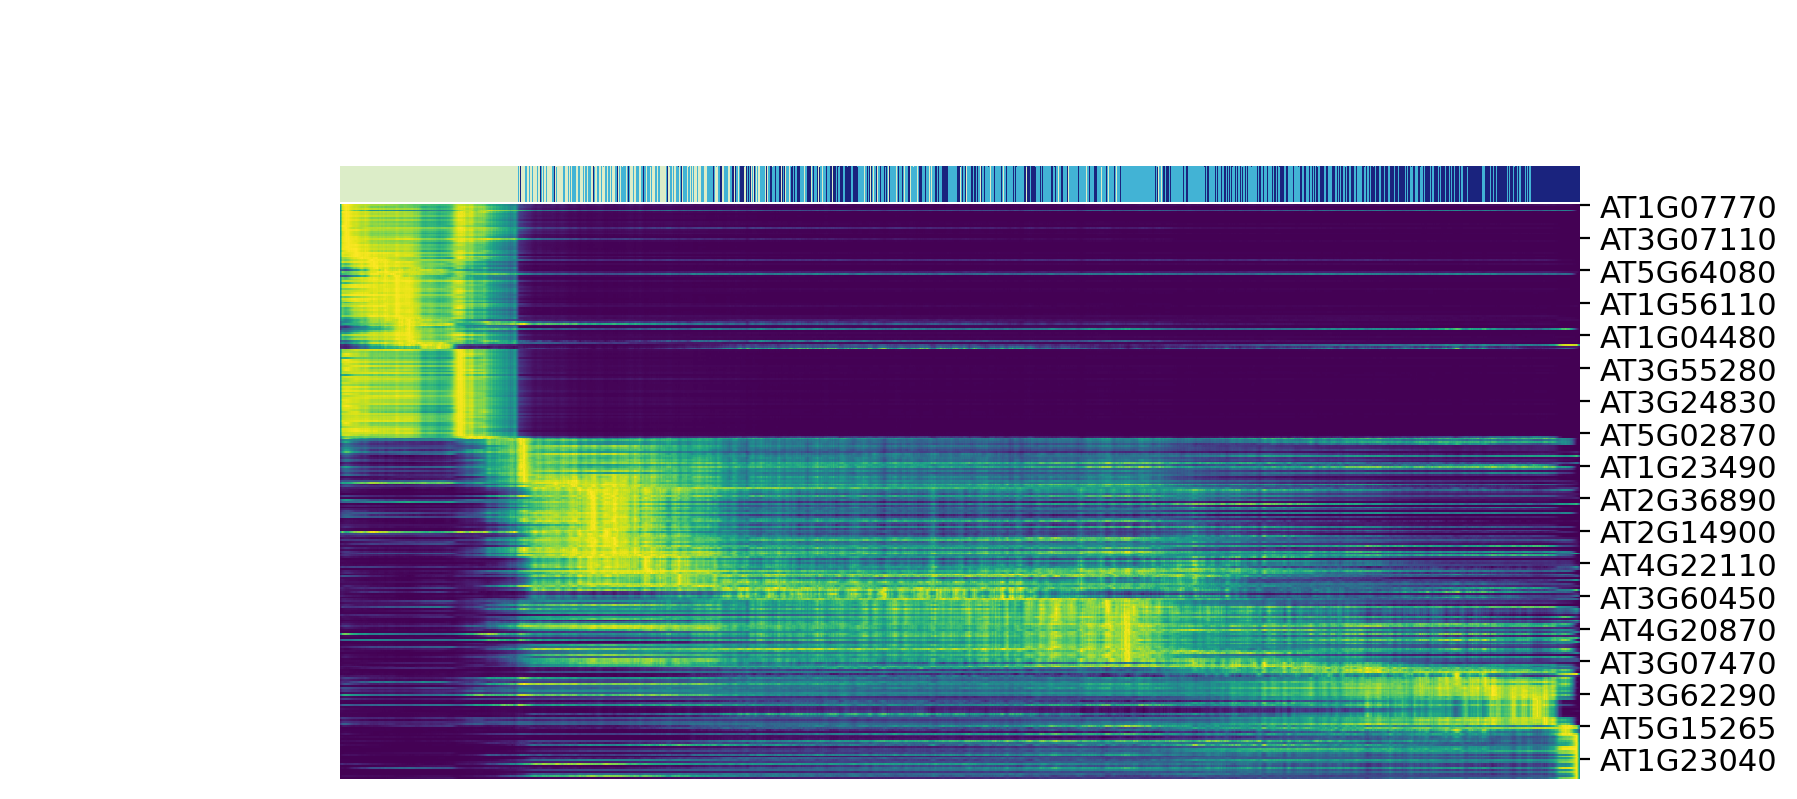

In [11]:
scv.tl.recover_latent_time(seu)
scv.pl.scatter(seu, color='latent_time', fontsize=24, size=100, color_map='plasma', perc=[2, 98], colorbar=True, rescale_color=[0,1], figsize=(9,9))
top_genes = seu.var_names[seu.var.fit_likelihood.argsort()[::-1]][:300]
scv.pl.heatmap(seu, var_names=top_genes, tkey='latent_time', n_convolve=100, col_color='time.anno')

In [12]:
# Save latent time
fname = "./supp_data/Ground_Tissue_Atlas_latent_time.txt"  # name to save file under
with open(fname, "w") as f:  # open the file as f
    for time in seu.obs['latent_time']:  # iterate over cells
        f.write(f"{time}\n")   # write each cell on a new line
f.close()